import library

In [1]:
import numpy as np
import os
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Load Dataset

In [2]:
IMAGE_SIZE = 264-5
IMAGE_SIZE = 264-5
BATCH_SIZE = 32
Channels = 3
epochs = 5

In [3]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Blood cell Cancer [ALL]",
    shuffle = True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 3242 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

In [5]:
len(dataset)

102

In [6]:

for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(259, 259, 3)


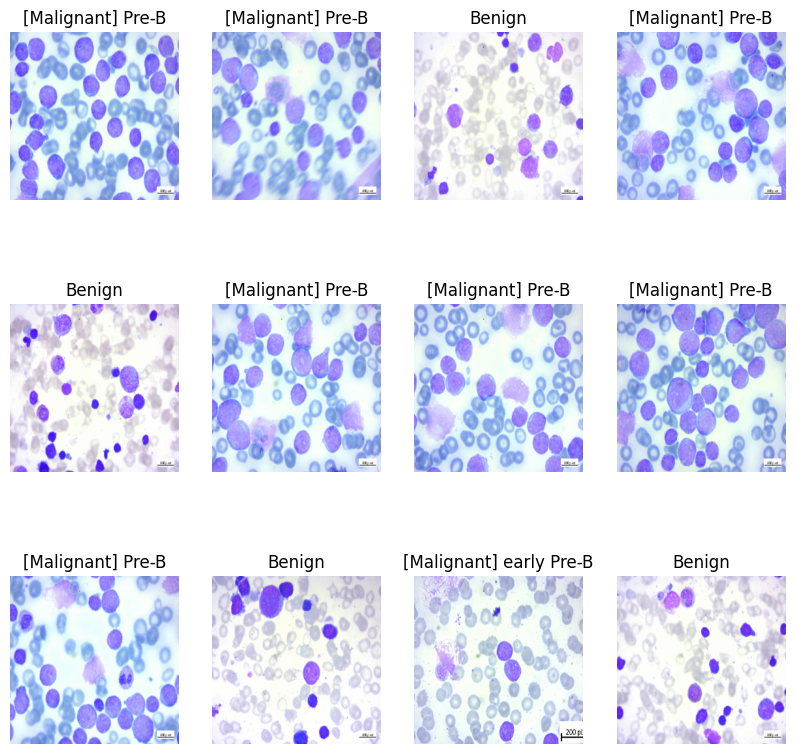

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
                 ax=plt.subplot(3,4,i+1)     
    
                 plt.imshow(image_batch[i].numpy().astype("uint8"))
                 plt.title(class_names[label_batch[i]])
                 plt.axis("off")
                  
                 
             

Spliting_Dataset

In [8]:
len(dataset)

102

In [11]:
#80% ==> training 
# 20% ==> 10% validation , 10% test

In [9]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)
      train_size = int(train_split*ds_size)
      val_size = int(val_split*ds_size)

      train_ds= ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds,test_ds

In [10]:
train_ds, val_ds,test_ds =get_dataset_partitions_tf(dataset)


In [11]:
len(train_ds)


81

In [12]:
len(test_ds)

11

In [13]:
len(val_ds)

10

Data preprocessing

In [14]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_filepath = "Blood cell Cancer [ALL]"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor ='val_accuracy',
    mode ='max',
    save_best_only=True,
    verbose=2
  
)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, Channels)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 259, 259, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 259, 259, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 257, 257, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 128, 128, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 126, 126, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                  

In [20]:

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [21]:
history = model.fit( 
    train_ds, 
    epochs= 2,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1
       )
 

Epoch 1/2
81/81 [==============================] - 127s 902ms/step - loss: 4.2677 - accuracy: 0.3335 - val_loss: 1.5137 - val_accuracy: 0.2906
Epoch 2/2
81/81 [==============================] - 68s 838ms/step - loss: 0.9880 - accuracy: 0.5953 - val_loss: 0.7678 - val_accuracy: 0.7344


In [22]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 6s 160ms/step - loss: 0.6729 - accuracy: 0.7472


In [23]:
scores

[0.6729177832603455, 0.7471590638160706]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 2, 'steps': 81}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

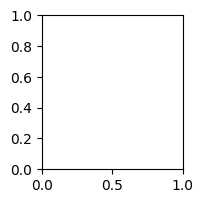

In [31]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc,label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')